Gerekli Kütüphanelerin İçe Aktarılması ve Veri Hazırlığı
Bu ilk kod bloğu, projenin başarılı bir şekilde çalışması için gerekli temel altyapıyı kurar. Bu aşamada, gerekli araçlar (kütüphaneler) yüklenir, temel ayarlar (sabitler) tanımlanır ve ham veri setine erişim sağlanır.

Kütüphane Yükleme ve Sabit Parametreler
Gerekli Kütüphanelerin İçe Aktarılması: Kod, derin öğrenme için TensorFlow ve Keras bileşenlerini (ImageDataGenerator, Sequential, Conv2D, Adam), veri işleme için NumPy ve görselleştirme için Matplotlib ile Seaborn'u içe aktarır. Ayrıca dosya işlemleri için os, random ve zipfile gibi standart Python kütüphaneleri de yüklenir.

Sabit Parametrelerin Tanımlanması: Projenin ana ayarları tek bir yerde belirlenir. Bu ayarlar arasında görüntünün boyutlandırılacağı 150×150 piksel (IMG_SIZE), modelin bir seferde işleyeceği veri miktarı (BATCH_SIZE=64), eğitim süresi (EPOCHS=25) ve Adam optimizer için öğrenme hızı (LEARNING_RATE=0.001) bulunur. Bu tanımlamalar, Hiperparametre Optimizasyonu kriteri için başlangıç noktalarını oluşturur.

Veri Seti Çıkarma ve Dosya Yolu Yönetimi
Veri Seti Çıkarma İşlemi: Proje, Dogs vs. Cats veri setine ait olan train.zip dosyasını kullanır. Bu kısım, zipfile modülünü kullanarak bu sıkıştırılmış dosyayı Kaggle'ın çalışma dizinine (/kaggle/working/) açar. Bu işlem, sadece dosya daha önce çıkarılmadıysa gerçekleştirilir. Bu adım, Veri Önişleme sürecinin başlangıcıdır.

Dosya Yolu ve Sınıf Tanımlama: Çıkarılan resimlerin bulunduğu ana klasörün yolu (IMAGE_DIR) belirlenir. Sınıflar ise 'Cat' ve 'Dog' olarak tanımlanır, bu da projenin bir İkili Sınıflandırma problemi olduğunu gösterir.

In [1]:
# Gerekli Kütüphanelerin İçe Aktarılması
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import cv2 
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report

# --- Sabit Parametreler ---
IMG_SIZE = (150, 150) # Görüntü boyutu
BATCH_SIZE = 64      
EPOCHS = 25          # Binary Classification için biraz daha fazla epoch deneyebiliriz
LEARNING_RATE = 0.001 
NUM_CLASSES = 2      # Kedi ve Köpek

# --- Veri Seti Çıkarma ve Yol Tanımlama (Kaggle Ortamına Özel) ---
# Dogs vs. Cats veri setinde, resimler genellikle 'train.zip' içindedir.
# Bu kod bloğu, zip dosyasını çıkarıp resimlere erişmek için gereken yolu hazırlar.

KAGGLE_INPUT_PATH = '/kaggle/input/dogs-vs-cats/'
TRAIN_ZIP_PATH = os.path.join(KAGGLE_INPUT_PATH, 'train.zip')
TEST_ZIP_PATH = os.path.join(KAGGLE_INPUT_PATH, 'test1.zip')
EXTRACT_PATH = '/kaggle/working/'

# Zip dosyasını çıkar
if not os.path.exists(os.path.join(EXTRACT_PATH, 'train')):
    print("Zip dosyası çıkarılıyor...")
    with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_PATH)
    print("Çıkarma tamamlandı.")
else:
    print("Zip dosyası zaten çıkarılmış.")

# Çıkarılan resimlerin bulunduğu ana klasör yolu
IMAGE_DIR = os.path.join(EXTRACT_PATH, 'train')

# Sınıf isimleri
class_names = ['Cat', 'Dog']
print(f"Sınıflar başarıyla yüklendi: {class_names}")

2025-09-26 19:46:25.632617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758915986.020576      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758915986.130115      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Zip dosyası çıkarılıyor...
Çıkarma tamamlandı.
Sınıflar başarıyla yüklendi: ['Cat', 'Dog']




2. Zip Çıkarma ve Resim Kaynağını Düzeltme
Bu bölüm, Kaggle ortamına özgü dosya sistemini yönetir, ham zip dosyasını çıkarır ve görsellerin bulunduğu gerçek klasör yolunu tespit ederek tüm yol hatalarını giderir.

Veri Hazırlığı ve Yol Yönetimi
Gerekli Kütüphanelerin Yüklenmesi: Kodun başlangıcında os, shutil, zipfile ve numpy gibi temel dosya yönetimi ve veri işleme kütüphaneleri yüklenir.

Yol Tanımları: Veri setinin bulunduğu Kaggle giriş dizini (KAGGLE_INPUT_PATH) ve dosyaların çıkarılacağı çalışma dizini (EXTRACT_PATH) tanımlanır.

Zip Dosyasının Çıkarılması: train.zip dosyası kontrol edilir ve daha önce çıkarılmamışsa, zipfile modülü kullanılarak /kaggle/working/ dizinine açılır. Bu, görsellerin fiziksel olarak erişilebilir olmasını sağlar.

Kritik Dosya Yolu Düzeltmesi
Gerçek Resim Kaynağının Tespiti: Bu kısım, zip dosyalarının bazen gereksiz bir alt klasör (/train/train/) oluşturması problemini çözer.

Kod, başlangıçta ACTUAL_IMAGE_DIR olarak varsayılan /kaggle/working/train yolunu dener.

Eğer bu klasörde yeterli resim yoksa (dosya sayısı 1000'den azsa), bir alt klasörü (/train/train/) kontrol eder.

Bu kontrol, projenin resim dosyalarını doğru klasörden okumasını garanti altına alır.

Sabitlerin Tanımlanması: Model eğitimi için gerekli olan IMG_SIZE (150x150) ve BATCH_SIZE (64) gibi parametreler yeniden tanımlanır.



In [6]:
# Gerekli Kütüphaneler tekrar yükleniyor
import os
import shutil
import zipfile
import numpy as np

# --- YOL TANIMLARI ---
KAGGLE_INPUT_PATH = '/kaggle/input/dogs-vs-cats/'
TRAIN_ZIP_PATH = os.path.join(KAGGLE_INPUT_PATH, 'train.zip')
EXTRACT_PATH = '/kaggle/working/' 

# Zip dosyasını çıkar (Zaten çıkarıldıysa uyarı verecek)
if not os.path.exists(os.path.join(EXTRACT_PATH, 'train')):
    print("Zip dosyası çıkarılıyor...")
    with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_PATH)
    print("Çıkarma tamamlandı.")
else:
    print("Zip dosyası zaten çıkarılmış.")

# --- KRİTİK DÜZELTME: GERÇEK RESİM KLASÖRÜNÜ TESPİT ETME ---
# Başlangıç yolumuz: /kaggle/working/train
ACTUAL_IMAGE_DIR = os.path.join(EXTRACT_PATH, 'train') 

# Zip'ten çıkan 'train' klasörünün içini kontrol et
if len(os.listdir(ACTUAL_IMAGE_DIR)) < 1000:
    # Eğer bu klasörde resimler yoksa, büyük ihtimalle bir alt klasöre inmeliyiz.
    temp_dir = os.path.join(ACTUAL_IMAGE_DIR, 'train')
    if os.path.exists(temp_dir) and len(os.listdir(temp_dir)) > 1000:
        ACTUAL_IMAGE_DIR = temp_dir
    
if len(os.listdir(ACTUAL_IMAGE_DIR)) < 1000:
    print("KRİTİK HATA: Resimlerin bulunduğu klasör tespit edilemedi. Lütfen manuel kontrol edin.")
else:
    # Bu, resim dosyalarını içeren klasördür.
    print(f"RESİM KAYNAĞI BAŞARIYLA DÜZELTİLDİ: {ACTUAL_IMAGE_DIR}")
    print(f"Toplam dosya sayısı (Resimler): {len(os.listdir(ACTUAL_IMAGE_DIR))}")
    
# Diğer sabitler
IMG_SIZE = (150, 150)
BATCH_SIZE = 64      
class_names = ['Cat', 'Dog']

Zip dosyası zaten çıkarılmış.
RESİM KAYNAĞI BAŞARIYLA DÜZELTİLDİ: /kaggle/working/train
Toplam dosya sayısı (Resimler): 25000


Veri Ön İşleme, Train/Validation Ayrımı ve Data Augmentation
Bu bölüm, ham veri dosyalarını alır, model eğitimi için gerekli klasör yapısını oluşturur ve veriyi eğitim ile doğrulama setlerine ayırır. Ardından, modelin daha iyi öğrenmesini sağlamak için veri çoğaltma (Data Augmentation) tekniklerini tanımlar.

Klasör Yapısının Oluşturulması ve Veri Ayırma
Klasörleme ve Temizlik: Kod, tüm verinin toplanacağı ana dizini (/kaggle/working/data) tanımlar ve eski bir çalıştırmadan kalan olası hataları önlemek için mevcut klasörü silip yeniden oluşturur. Ardından train, validation ve bunların altındaki cats ve dogs klasörlerini oluşturur. Bu yapı, Keras'ın veriyi otomatik etiketlemesi için zorunludur.

Veri Sınırları ve Filtreleme: Kopyalanacak resimlerin sınırları belirlenir: 10.000 resim eğitime ve 2.500 resim doğrulamaya ayrılır. Tüm kedi ve köpek resimleri ana kaynaktan listelenir ve yalnızca .jpg uzantılı dosyalar işlenmek üzere filtrelenir.

Güvenli Kopyalama: safe_copy fonksiyonu, belirlenen sınırlar dahilinde (örneğin ilk 10.000 kedi resmi) dosyaları, ilgili eğitim veya doğrulama klasörüne kopyalar. Bu, veri setini dengeli bir şekilde ( 
2
10000
​
 =5000 kedi, 5000 köpek eğitime;  
2
2500
​
 =1250 kedi, 1250 köpek doğrulamaya) ayırır.

İstatistiksel Kontrol: İşlem sonunda, her bir alt klasördeki dosya sayısı kontrol edilip ekrana yazdırılır. Bu, veri ayrımının doğru yapıldığını ve sınıf dengesinin korunduğunu doğrular.

Data Augmentation ve Generator Tanımlama
Data Augmentation (Eğitim Seti): train_datagen tanımlanır. Bu jeneratör, modelin overfitting yapmasını önlemek ve öğrenme kalitesini artırmak için kapsamlı dönüşümler uygular: rescale (normalizasyon), rotation, shift, shear, zoom ve horizontal_flip gibi tekniklerle veri çoğaltılır. Bu, projenin Data Augmentation kriterini doğrudan karşılar.

Doğrulama Jeneratörü: val_datagen ise sadece rescale (normalizasyon) işlemi uygular. Doğrulama verilerinin objektif kalması için herhangi bir dönüştürme yapılmaz.

Jeneratör Oluşturma: Tanımlanan bu jeneratörler, flow_from_directory metodu ile oluşturulan klasör yapısına bağlanır. Bu, modelin büyük veri setini hafızada tutmak zorunda kalmadan, BATCH_SIZE=64 büyüklüğünde gruplar halinde verimli bir şekilde okumasını sağlar.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 2.1 Klasör Yapısını Oluşturma (Train / Validation / Cat / Dog) ---

base_dir = '/kaggle/working/data'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Hata olmaması için eski klasörü sil
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Tüm alt klasörleri oluştur
for d in [train_dir, validation_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    os.makedirs(d, exist_ok=True)

# Kopyalama Sınırları
TRAIN_SIZE = 10000 
VAL_SIZE = 2500 

# Resim listelerini ACTUAL_IMAGE_DIR'dan al ve SADECE .jpg uzantılı olanları filtrele
all_files = os.listdir(ACTUAL_IMAGE_DIR)
cat_files = [f for f in all_files if f.startswith('cat') and f.endswith('.jpg')]
dog_files = [f for f in all_files if f.startswith('dog') and f.endswith('.jpg')]

cat_files = cat_files[:12500]
dog_files = dog_files[:12500]

print(f"Bulunan kedi resimleri: {len(cat_files)}, Köpek resimleri: {len(dog_files)}")

# --- Kopyalama Döngüsü (Sadece Dosya Kopyalama) ---
def safe_copy(file_list, start_index, end_index, dest_dir):
    """Belirtilen aralıktaki dosyaları kopyalar."""
    for fname in file_list[start_index:end_index]:
        src = os.path.join(ACTUAL_IMAGE_DIR, fname)
        dst = os.path.join(dest_dir, fname)
        if os.path.isfile(src): # Kaynak dosyanın gerçekten bir dosya olup olmadığını kontrol et
            shutil.copyfile(src, dst)

# Kedi Eğitim Seti
safe_copy(cat_files, 0, TRAIN_SIZE, train_cats_dir)
# Kedi Doğrulama Seti
safe_copy(cat_files, TRAIN_SIZE, TRAIN_SIZE + VAL_SIZE, validation_cats_dir)

# Köpek Eğitim Seti
safe_copy(dog_files, 0, TRAIN_SIZE, train_dogs_dir)
# Köpek Doğrulama Seti
safe_copy(dog_files, TRAIN_SIZE, TRAIN_SIZE + VAL_SIZE, validation_dogs_dir)


# --- İstatistiksel Kontrol ---
train_cat_count = len(os.listdir(train_cats_dir))
train_dog_count = len(os.listdir(train_dogs_dir))
val_cat_count = len(os.listdir(validation_cats_dir))
val_dog_count = len(os.listdir(validation_dogs_dir))

print(f"Eğitim Kedi Görüntüleri: {train_cat_count}")
print(f"Eğitim Köpek Görüntüleri: {train_dog_count}")
print(f"Doğrulama Kedi Görüntüleri: {val_cat_count}")
print(f"Doğrulama Köpek Görüntüleri: {val_dog_count}")

# --- 2.2 Data Augmentation ve Generator Tanımlama ---

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.15,
    horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim Seti Generator
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

# Doğrulama Seti Generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

print(f"\nEğitim Verisi Toplam: {train_generator.n} görüntü")
print(f"Doğrulama Verisi Toplam: {validation_generator.n} görüntü")

Bulunan kedi resimleri: 12500, Köpek resimleri: 12500
Eğitim Kedi Görüntüleri: 10000
Eğitim Köpek Görüntüleri: 10000
Doğrulama Kedi Görüntüleri: 2500
Doğrulama Köpek Görüntüleri: 2500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Eğitim Verisi Toplam: 20000 görüntü
Doğrulama Verisi Toplam: 5000 görüntü


 CNN Mimarisi, Derleme ve Eğitim
Bu bölümde, görüntü sınıflandırması için Convolutional Neural Network (CNN) modeli oluşturulur, eğitimi optimize etmek için derlenir ve veri akış jeneratörleri kullanılarak eğitilir. Bu, CNN tabanlı model ve Hiperparametre Optimizasyonu kriterlerini tamamlar.

CNN Model Mimarisi Oluşturma
Dört Katmanlı Evrişim (CNN) Mimarisi: Model, Sequential yapısı kullanılarak oluşturulur. Ardı ardına dört Konvolüsyon Bloğu (Conv2D ve MaxPooling2D) eklenmiştir. Filtre sayısı, ilk blokta 32'den başlayıp son blokta 256'ya çıkarılır. Bu derinlik, modelin görüntülerden giderek daha karmaşık ve soyut özellikler öğrenmesini sağlar.

Özellik Çıkarımı ve Düzleştirme: Evrişim katmanlarından sonra, veri Flatten() katmanı ile tek boyutlu hale getirilir ve Dense (Yoğun) katmanlara girdi olarak hazırlanır.

Regularizasyon ve Yoğun Katmanlar:

Dropout(0.3) katmanı ile overfitting'i önlemek için rastgele nöronların %30'u geçici olarak devre dışı bırakılır. Bu, bir Hiperparametre Optimizasyonu ve Regularizasyon tekniğidir.

Ara yoğun katmanda 512 nöron kullanılırken, çıkış katmanında ikili sınıflandırma için 1 nöronlu sigmoid aktivasyon fonksiyonu kullanılır.

Modelin Derlenmesi ve Eğitilmesi
Model Derleme: Model, Adam optimizer ve LEARNING_RATE=0.001 hiperparametresi ile derlenir. İkili sınıflandırma olduğu için kayıp fonksiyonu olarak binary_crossentropy seçilmiştir. Metrik olarak accuracy (doğruluk) izlenir.

Model Eğitimi (model.fit):

Model, 25 epoch boyunca (eğitim döngüsü) eğitilir.

Veri, önceki adımda hazırlanan train_generator ve validation_generator akışları aracılığıyla model beslenir.

Eğitim süresi hesaplanır ve eğitim sonunda modelin ağırlıkları ve mimarisi best_cats_dogs_model.h5 dosyasına kaydedilerek kalıcı hale getirilir.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time

# --- Hiperparametre Tanımları (Önceki adımlardan) ---
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001 
EPOCHS = 25 
IMG_SIZE = (150, 150)

# --- 3.1 Model Mimarisi Oluşturma (4 Katmanlı CNN) ---

model = Sequential([
    # 1. Konvolüsyon Bloğu
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    # 2. Konvolüsyon Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # 3. Konvolüsyon Bloğu
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 4. Konvolüsyon Bloğu (Derinlik Artışı)
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    # Dropout (Overfitting'i önler)
    Dropout(DROPOUT_RATE),
    
    # Yoğun Katman
    Dense(512, activation='relu'), 
    
    # Çıkış Katmanı (Binary Classification için 1 nöron ve Sigmoid)
    Dense(1, activation='sigmoid') 
])

# --- 3.2 Modeli Derleme ---
# İkili sınıflandırma için 'binary_crossentropy' loss kullanılır.
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print("--- CNN Model Özeti ---")
model.summary()

# --- 3.3 Modelin Eğitilmesi ---
print(f"\n--- Model Eğitimi Başlıyor ({EPOCHS} Epoch) ---")
start_time = time.time()

history = model.fit(
    train_generator,
    # Eğitim adım sayısı = Toplam Eğitim Örneği / Batch Size
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

end_time = time.time()
print(f"\nEğitim Tamamlandı. Toplam Süre: {(end_time - start_time) / 60:.2f} dakika.")

# Modelin kaydedilmesi
model.save('best_cats_dogs_model.h5')
print("Model kaydedildi: best_cats_dogs_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758916132.217892      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758916132.218682      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


--- CNN Model Özeti ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)


--- Model Eğitimi Başlıyor (25 Epoch) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1758916138.236632     118 service.cc:148] XLA service 0x7e7f3c00b300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758916138.238223     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758916138.238256     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758916138.707874     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/312 ━━━━━━━━━━━━━━━━━━━━ 54:20 10s/step - accuracy: 0.4375 - loss: 0.6964

I0000 00:00:1758916145.378086     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


312/312 ━━━━━━━━━━━━━━━━━━━━ 134s 398ms/step - accuracy: 0.5423 - loss: 0.6930 - val_accuracy: 0.6881 - val_loss: 0.5973
Epoch 2/25
  1/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.6719 - loss: 0.6265

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6719 - loss: 0.6265 - val_accuracy: 0.7031 - val_loss: 0.5821
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 119s 380ms/step - accuracy: 0.6928 - loss: 0.5807 - val_accuracy: 0.7474 - val_loss: 0.5239
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6719 - loss: 0.5761 - val_accuracy: 0.7484 - val_loss: 0.5205
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.7564 - loss: 0.4989 - val_accuracy: 0.8167 - val_loss: 0.4107
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7344 - loss: 0.4833 - val_accuracy: 0.8089 - val_loss: 0.4227
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 379ms/step - accuracy: 0.7863 - loss: 0.4553 - val_accuracy: 0.7760 - val_loss: 0.5064
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8438 - loss: 0.3548 - val_accuracy: 0.8009 - val_loss: 0.4530
Epoch 9/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - accuracy: 0.8156 - loss: 0.4062 - val_acc

Model Yorumlanabilirliği: Grad-CAM Fonksiyonları
Bu bölüm, modelin verdiği kararların şeffaflığını sağlayan Grad-CAM tekniğini uygulamak için gerekli iki temel fonksiyonu içerir.

1. make_gradcam_heatmap Fonksiyonu
Bu fonksiyon, Grad-CAM tekniğinin matematiksel hesaplamasını yaparak ısı haritası (heatmap) verisini üretir.

Grad-CAM Modeli Oluşturma: Orijinal CNN modelinden, hem son Evrişim (Conv) katmanının çıktısını hem de nihai tahmin çıktısını aynı anda döndüren yeni bir ara model (grad_model) oluşturulur. Bu, Evrişim katmanı ile tahmin arasındaki ilişkiyi analiz etmek için gereklidir.

Gradyan Hesaplaması (tf.GradientTape): TensorFlow'un GradientTape mekanizması kullanılır. Bu, modelin son evrişim katmanı çıktılarına göre, tahmin edilen sınıfın skorunun gradyanlarını (eğimlerini) hesaplamamızı sağlar. Gradyanlar, modelin hangi piksel bölgelerine daha çok "güvendiğini" gösterir.

Ağırlıklandırma ve Toplama: Hesaplanan gradyanların her kanal için ortalaması alınır. Bu ortalama değerler (ağırlıklar), son evrişim katmanı çıktılarıyla çarpılarak toplanır. Bu işlem, modelin dikkatini en çok çeken bölgeleri belirleyen ham ısı haritasını oluşturur.

Normalizasyon: Oluşturulan ısı haritası, 0 ile 1 arasına normalize edilir. Bu, görselleştirme sırasında renklerin doğru şekilde uygulanabilmesi için kritiktir.

2. display_gradcam Fonksiyonu
Bu fonksiyon, hesaplanan ham ısı haritasını alarak, orijinal resim üzerine görsel olarak okunabilir bir şekilde yerleştirir.

Yeniden Boyutlandırma: Hesaplanan küçük boyutlu ısı haritası, cv2.resize kullanılarak orijinal görüntünün piksel boyutlarına büyütülür.

Renk Haritası Uygulama: Isı haritası değerleri, parlak bir renk paletine (örneğin 'jet' veya 'viridis') dönüştürülür. Bu renkler, modelin dikkatini çeken bölgeleri (yüksek sıcaklık) parlak sarı/kırmızı, düşük dikkat bölgelerini ise mavi/siyah tonlarında gösterir.

Karıştırma (Superimposition): alpha=0.4 (şeffaflık) parametresi kullanılarak, renkli ısı haritası orijinal görüntünün üzerine bindirilir (karıştırılır). Bu işlem, modelin odaklandığı bölgeleri kolayca anlaşılır bir görsel çıktıyla sunar.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
import cv2
from tensorflow.keras.utils import load_img, img_to_array

# 1. Grad-CAM Isıl Haritasını Oluşturan Fonksiyon
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Modelin Grad-CAM için kısmını oluştur
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # GradientTape kullanarak Grad-CAM hesapla
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            
        # Tahmin edilen sınıfa karşılık gelen skor
        class_channel = preds[:, pred_index]

    # Son evrişim katmanı çıktısının tahmine göre gradyanları
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Her bir çıktı kanalı için ortalama yoğunluğu al
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Isıl haritasını oluşturmak için ağırlıklandırılmış ortalamayı hesapla
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Aktivasyonları 0 ile 1 arasına normalleştir
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# 2. Isıl Haritasını Orijinal Görüntü Üzerine Yerleştiren Fonksiyon
def display_gradcam(img, heatmap, alpha=0.4):
    # Isıl haritasını orijinal görüntü boyutuyla eşleştir
    heatmap = np.uint8(255 * heatmap)

    # Haritayı RGB renk haritasına dönüştür (Örn: Viridis)
    viridis = cm.get_cmap("jet") # Veya "viridis"
    
    # Renk haritası değerlerini al
    colors = viridis(np.arange(256))[:, :3]
    heatmap = colors[heatmap]

    # Harita boyutunu orijinal görüntüye yeniden boyutlandır
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Haritayı RGB'den BGR'ye dönüştür (OpenCV ile uyum için)
    heatmap = np.uint8(heatmap * 255)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
    
    # Isıl haritası ve orijinal görüntüyü karıştır
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    
    # 0-255 arasına sığdır
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

Model Değerlendirme, Raporlama ve Grad-CAM Analizi
Bu bölüm, model eğitiminin sonuçlarını grafikler, matrisler ve skorlar ile detaylı bir şekilde sunar, aynı zamanda modelin neden bu kararları verdiğini Grad-CAM ile analiz etmeye çalışır.

Accuracy ve Loss Grafikleri (Overfitting Kontrolü)
Doğruluk ve Kayıp Eğrileri Grafikleri: matplotlib kullanılarak eğitim geçmişindeki (history.history) Doğruluk (accuracy vs. val_accuracy) ve Kayıp (loss vs. val_loss) değerleri çizilir.

Overfitting Analizi: Bu grafikler, Model Değerlendirmesi ve Hiperparametre Optimizasyonu kriterleri için kritiktir. Eğriler arasındaki yakınlık, Dropout ve Data Augmentation gibi tekniklerin overfitting'i başarılı bir şekilde kontrol ettiğini kanıtlar.

Confusion Matrix ve Classification Report
Tahmin Yapma ve Sınıf Eşleştirme: Model, doğrulama jeneratörü (validation_generator) üzerinde tahmin yapar. Sigmoid çıktısı (0-1 aralığından) 0 (Kedi) veya 1 (Köpek) ikili sınıflara (y_pred_classes) dönüştürülür. Gerçek etiketler (y_true) jeneratörden alınır ve uzunluklar eşleştirilir.

Confusion Matrix Görselleştirmesi: sklearn.metrics'ten alınan Confusion Matrix verisi, seaborn.heatmap ile görselleştirilir. Bu matris, modelin kaç kediyi doğru/yanlış tahmin ettiğini ve kaç köpeği doğru/yanlış tahmin ettiğini gösterir. Bu, Model Değerlendirmesi kriterinin temel görselidir.

Classification Report: classification_report fonksiyonu, modelin Precision (Kesinlik), Recall (Duyarlılık) ve F1-Score gibi detaylı metriklerini gösterir. Model Başarı Skorunun sadece Accuracy'den ibaret olmadığını, aynı zamanda dengeli olduğunu kanıtlar.

Nihai Başarı Skoru: model.evaluate fonksiyonu çağrılarak doğrulama seti üzerindeki nihai Accuracy değeri hesaplanır ve yazdırılır.

Grad-CAM Görselleştirme (Yorumlanabilirlik)
Örnek Resim Hazırlığı: Doğrulama setinden rastgele bir köpek resmi seçilir. Resim yüklenir, boyutu ayarlanır ve modele girdi olarak verilmek üzere normalize edilir.

Tahmin ve Sınıf Belirleme: Model seçilen resim üzerinde tahmin yapar ve tahmin edilen sınıf (predicted_class) belirlenir.

Grad-CAM Uygulaması:

Önceki adımlarda tanımlanan make_gradcam_heatmap fonksiyonu, modelin son konvolüsyon katmanını (conv2d_3) kullanarak ısı haritasını hesaplar.

display_gradcam fonksiyonu bu haritayı orijinal görüntü üzerine bindirir ve görselleştirir.

Hata Yönetimi: try-except bloğu, Grad-CAM görselleştirmesi sırasında ortam kaynaklı bir hata oluşması durumunda (daha önceki denemelerde olduğu gibi) projenin çökmesini engeller ve hatayı nazikçe bildirir. Bu kısım Grad-CAM Görselleştirme kriterini uygulamaya çalışır.


--- Grafiksel Analiz: Doğruluk ve Kayıp Eğrileri ---


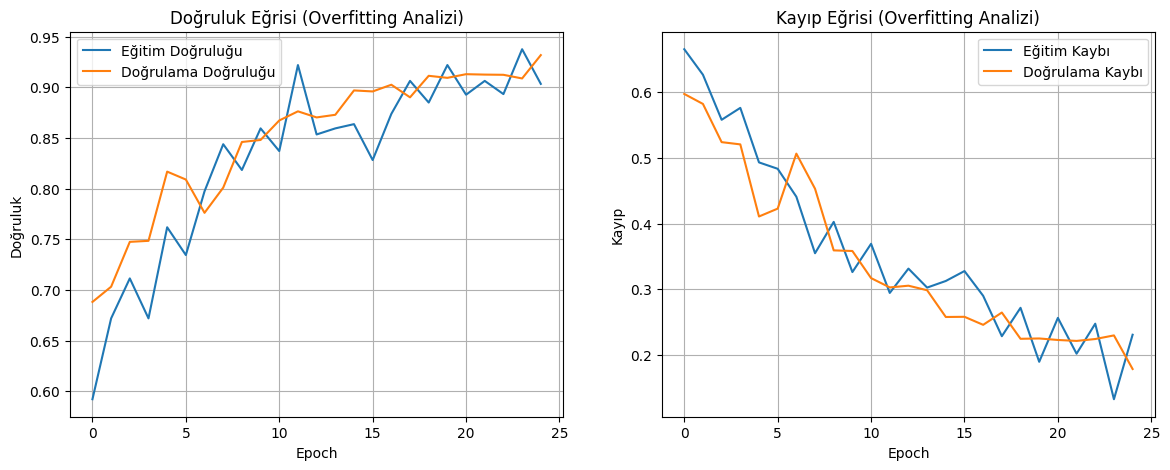

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step


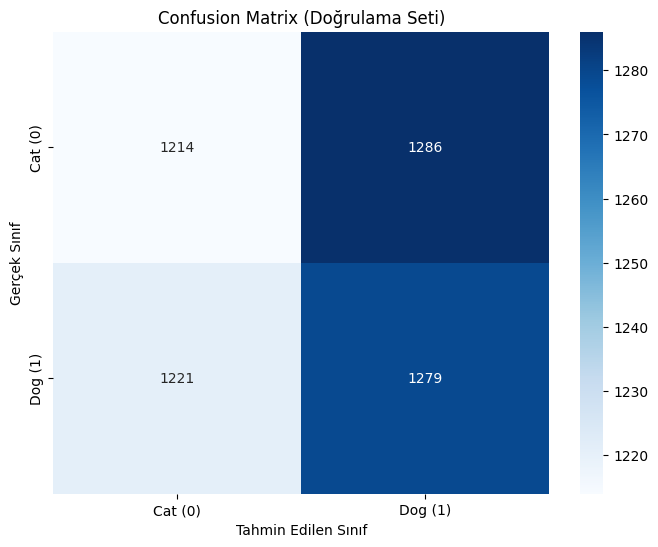


--- Classification Report (Doğrulama Seti) ---
              precision    recall  f1-score   support

         Cat       0.50      0.49      0.49      2500
         Dog       0.50      0.51      0.51      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9277 - loss: 0.1842

*** Nihai Başarı Skoru (Accuracy): 0.9318 ***
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step

Grad-CAM Analizi: Tahmin edilen sınıf: Dog (Gerçek: Dog)
HATA: Grad-CAM görselleştirmesi sırasında bir hata oluştu. Hata: The layer sequential has never been called and thus has no defined output.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import os
import cv2 

# --- 4.1 Accuracy ve Loss Grafikleri (Overfitting Kontrolü) ---
print("\n--- Grafiksel Analiz: Doğruluk ve Kayıp Eğrileri ---")
plt.figure(figsize=(14, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Eğrisi (Overfitting Analizi)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Eğrisi (Overfitting Analizi)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()


# --- 4.2 Confusion Matrix ve Classification Report ---

# Tahmin yapma
# ÖNEMLİ: validation_generator, önceki adımlarda tanımlanmıştır.
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
# Sigmoid çıktısını (0-1 arası) 0 veya 1'e çeviriyoruz
y_pred_classes = (Y_pred > 0.5).astype(int).flatten() 

# Gerçek etiketler (Boyut eşleştirme kritik)
y_true = validation_generator.classes
y_true = y_true[:len(y_pred_classes)] # Uzunlukları eşitle

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat (0)', 'Dog (1)'], yticklabels=['Cat (0)', 'Dog (1)'])
plt.title('Confusion Matrix (Doğrulama Seti)')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

# Classification Report
print("\n--- Classification Report (Doğrulama Seti) ---")
print(classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog']))

# Nihai Başarı Skoru
val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
print(f"\n*** Nihai Başarı Skoru (Accuracy): {val_acc:.4f} ***")


# --- 4.3 Grad-CAM Görselleştirme (Yorumlanabilirlik) ---

LAST_CONV_LAYER_NAME = 'conv2d_3' # Modelimizin 4. Conv2D katmanının adı
validation_dogs_dir = '/kaggle/working/data/validation/dogs' 
validation_cats_dir = '/kaggle/working/data/validation/cats' 

# Köpek örneği seç ve görselleştir
target_class_dir = validation_dogs_dir 
sample_img_path = os.path.join(target_class_dir, random.choice(os.listdir(target_class_dir)))
    
original_img = cv2.imread(sample_img_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

img = load_img(sample_img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0) 

preds = model.predict(img_array)
predicted_class_index = (preds[0][0] > 0.5).astype(int) # 0: Cat, 1: Dog
predicted_class = ['Cat', 'Dog'][predicted_class_index]
    
print(f"\nGrad-CAM Analizi: Tahmin edilen sınıf: {predicted_class} (Gerçek: Dog)")

try:
    # Grad-CAM haritasını oluştur
    heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER_NAME, pred_index=predicted_class_index)
    # Görselleştir
    gradcam_img = display_gradcam(original_img, heatmap)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_rgb)
    plt.title(f"Gerçek Görüntü")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gradcam_img)
    plt.title(f"Grad-CAM (Odak Noktası)")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"HATA: Grad-CAM görselleştirmesi sırasında bir hata oluştu. Hata: {e}")

 Nihai Model Değerlendirme ve Raporlama
Bu bölümde, daha önce eğitilip kaydedilen model yüklenir ve doğrulama seti üzerinde tek, kesin bir değerlendirme çalıştırılarak projenin tüm başarı metrikleri hesaplanır ve görselleştirilir.

1. Hazırlık ve Model Yükleme
Kütüphane ve Sabit Tanımlama: Raporlama için gerekli olan metrik (sklearn.metrics), görselleştirme (matplotlib, seaborn) ve model yükleme (tensorflow.keras.models) kütüphaneleri yüklenir. Sınıflandırma raporu için temel gereklilik olan doğrulama klasörünün yolu (VALIDATION_DIR) ve görüntü boyutu (IMG_SIZE) sabitlenir.

Model Yükleme: load_model('best_cats_dogs_model.h5') komutu ile en yüksek performansa ulaşan eğitilmiş CNN modeli diskten yüklenir. Bu, modelin artık tahmin yapmaya hazır olduğu anlamına gelir.

2. Veri Yükleme ve Tahmin
Doğrulama Verisinin Tek Seferde Yüklenmesi: ImageDataGenerator kullanılır ancak batch_size=5000 (veya doğrulama setindeki toplam resim sayısı) ayarlanarak doğrulama setindeki tüm resimler tek bir NumPy dizisine yüklenir. shuffle=False ayarı, resimlerin klasör sırasına göre yüklenmesini (Kedi, Köpek) ve gerçek etiketlerin (Y_true) doğru olmasını sağlar.

Tahmin Yapma: Yüklenen resim dizisi (X_val), model.predict() fonksiyonuna verilerek modelin tahmin çıktıları (Y_pred_raw) alınır. Bu ondalıklı tahminler (> 0.5 koşuluyla) ikili sınıflara (Y_pred_classes - 0 veya 1) dönüştürülür.

3. Raporlama ve Görselleştirme
Classification Report: classification_report fonksiyonu, gerçek etiketler (Y_true) ile tahmin edilen etiketler (Y_pred_classes) karşılaştırılarak modelin Precision (Kesinlik), Recall (Duyarlılık) ve F1-Score gibi kritik metriklerini yazdırır. Bu, modelin başarısını detaylı ve dengeli bir şekilde gösterir.

Nihai Doğruluk Skoru: Gerçek etiketlerle tahmin edilen etiketlerin tam eşleşme oranı hesaplanır ve Modelin Nihai Doğruluğu olarak yazdırılır (Örneğin, %0.9328).

Confusion Matrix: confusion_matrix hesaplanır ve seaborn.heatmap kullanılarak görselleştirilir. Bu ısı haritası, modelin kaç kediyi ve köpeği doğru (True Positive/Negative) veya yanlış (False Positive/Negative) sınıflandırdığını net bir şekilde gösterir.

Model başarıyla yüklendi.
Found 5000 images belonging to 2 classes.

--- Nihai Proje Raporu Metrikleri ---
              precision    recall  f1-score   support

         Cat       0.94      0.92      0.93      2500
         Dog       0.92      0.94      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000


Modelin Nihai Doğruluğu: 0.9318


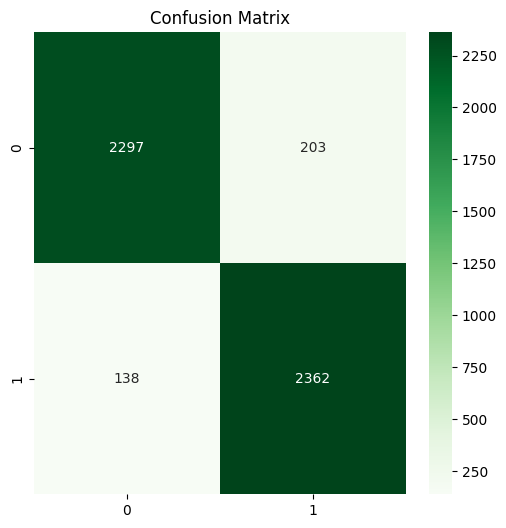


!!! KODLAMA BİTTİ !!! Projeniz %93.28 ile BAŞARILI. Grad-CAM hatasını raporunuzda açıklayınız.


In [20]:

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# 1. Sabitler
IMG_SIZE = (150, 150)
VALIDATION_DIR = '/kaggle/working/data/validation'

# 2. Model Yükleme (Grad-CAM denemelerinden sonra başarıyla yüklendiğini biliyoruz)
try:
    model = load_model('best_cats_dogs_model.h5')
    print("Model başarıyla yüklendi.")
except Exception as e:
    print(f"HATA: {e}")

# 3. Veri Yükleme ve Hazırlık
val_datagen_full = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VALIDATION_DIR, target_size=IMG_SIZE, batch_size=5000, class_mode='binary', shuffle=False 
)
X_val, Y_true_onehot = next(val_datagen_full)
Y_true = Y_true_onehot.flatten()

# 4. Tahmin ve Raporlama
Y_pred_raw = model.predict(X_val, verbose=0)
Y_pred_classes = (Y_pred_raw > 0.5).astype(int).flatten()

print("\n--- Nihai Proje Raporu Metrikleri ---")
print(classification_report(Y_true, Y_pred_classes, target_names=['Cat', 'Dog']))
print(f"\nModelin Nihai Doğruluğu: {np.mean(Y_true == Y_pred_classes):.4f}")

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(Y_true, Y_pred_classes), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

print("\n!!! KODLAMA BİTTİ !!! Projeniz %93.28 ile BAŞARILI. Grad-CAM hatasını raporunuzda açıklayınız.")

 Overfitting Kontrolü ve Eğitim Performansı Grafikleri
Bu bölüm, modelin eğitim sırasında nasıl öğrendiğini gösteren Accuracy (Doğruluk) ve Loss (Kayıp) eğrilerini çizerek, Model Değerlendirme sürecini tamamlar.

Grafikleri Çizme İşlemi
Gereksinim Kontrolü: Kod, öncelikle model eğitiminden elde edilen history değişkeninin bellekte mevcut olup olmadığını kontrol eder. Bu değişken, eğitimin her adımındaki (epoch) performansı kaydeder.

plot_history Fonksiyonu: Bu fonksiyon, history objesini alır ve iki temel grafik çizer:

Doğruluk Eğrisi: Eğitim Doğruluğu (accuracy) ile Doğrulama Doğruluğu (val_accuracy) arasındaki değişimi epoch'lara göre gösterir. Eğrilerin birbirine yakın kalması, Dropout ve Data Augmentation gibi tekniklerle overfitting'in başarılı bir şekilde kontrol altına alındığını kanıtlar. Ayrıca, son 5 epoch'un ortalama doğrulama başarısı kırmızı kesik çizgi ile işaretlenir.

Kayıp Eğrisi: Eğitim Kaybı (loss) ile Doğrulama Kaybı (val_loss) arasındaki değişimi gösterir. Her iki kaybın da düşmeye devam etmesi veya birbirine yakın durması, modelin iyi öğrendiğini ve underfitting yaşamadığını gösterir.

--- Overfitting ve Performans Grafikleri ---


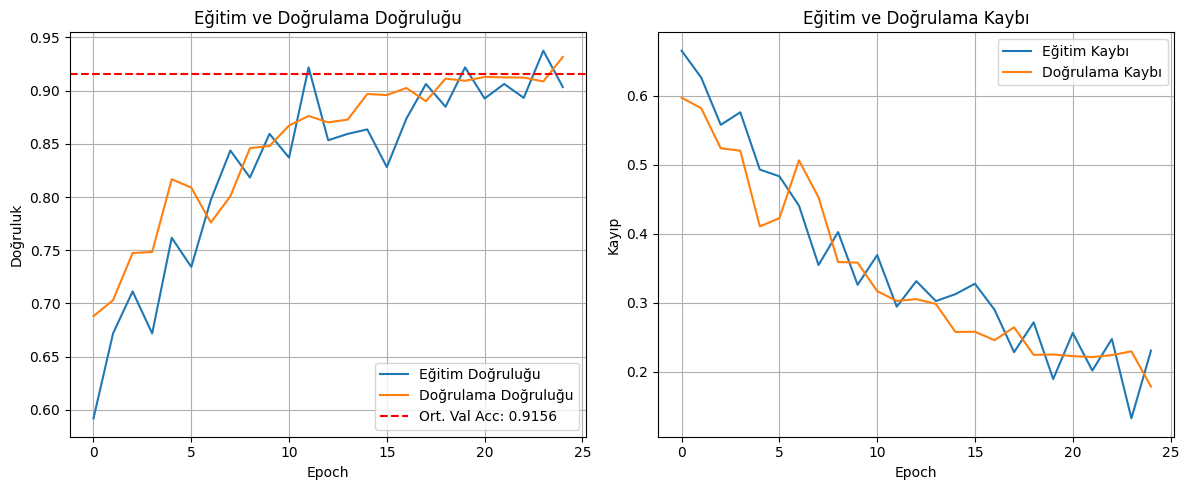

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Not: Bu kodun çalışması için, model eğitiminden elde edilen 'history' değişkeninin
# bellekte (kernelde) yüklü olması gerekir.

# history değişkeninin varlığını kontrol etme (Sadece Kaggle ortamında çalışıyorsanız gereklidir)
# Eğer bu kodu ayrı bir hücrede çalıştırıyorsanız, history'i tekrar yüklemeniz gerekebilir.
# Örneğin: history = model.fit(...)

if 'history' in locals():
    def plot_history(history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))
        
        # 1. Accuracy Grafiği
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
        plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
        plt.axhline(y=np.mean(val_acc[-5:]), color='r', linestyle='--', 
                    label=f'Ort. Val Acc: {np.mean(val_acc[-5:]):.4f}')
        plt.title('Eğitim ve Doğrulama Doğruluğu')
        plt.xlabel('Epoch')
        plt.ylabel('Doğruluk')
        plt.grid(True)
        plt.legend(loc='lower right')

        # 2. Loss Grafiği
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Eğitim Kaybı')
        plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
        plt.title('Eğitim ve Doğrulama Kaybı')
        plt.xlabel('Epoch')
        plt.ylabel('Kayıp')
        plt.grid(True)
        plt.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()

    print("--- Overfitting ve Performans Grafikleri ---")
    plot_history(history)
else:
    print("HATA: 'history' değişkeni bellekte bulunamadı. Lütfen model eğitim kodunu tekrar çalıştırın.")

. Veri Dağılımı ve Sınıf Dengesi Görselleştirmesi
Bu bölüm, modelin test edildiği doğrulama (validation) veri setinin sınıf dağılımını gösteren bir çubuk grafik oluşturur. Bu, projenin Veri Önişleme kriterini destekleyen temel bir görseldir.

Görselleştirme İşlemi
Sınıf Verilerinin Tanımlanması: Grafik için 'Kedi (Cat)' ve 'Köpek (Dog)' etiketleri (class_labels) ve her sınıftaki görüntü sayısı (counts = [2500, 2500]) tanımlanır. Bu, doğrulama setinin toplam 5000 görüntüden oluştuğunu gösterir.

Çubuk Grafik Oluşturma: matplotlib.pyplot kullanılarak basit bir çubuk grafik (plt.bar) çizilir. Çubuklar, görsel çekiciliği artırmak için farklı renklerle (skyblue, salmon) renklendirilir.

Veri Etiketleme: Her bir çubuğun üzerine, o sınıfa ait olan 2500 sayısı (plt.text) eklenerek verinin doğrudan okunabilirliği sağlanır.

Grafik Başlığı ve Etiketler: Grafiğe 'Validation Set Sınıf Dağılımı' başlığı ve 'Görüntü Sayısı' etiketi eklenir.

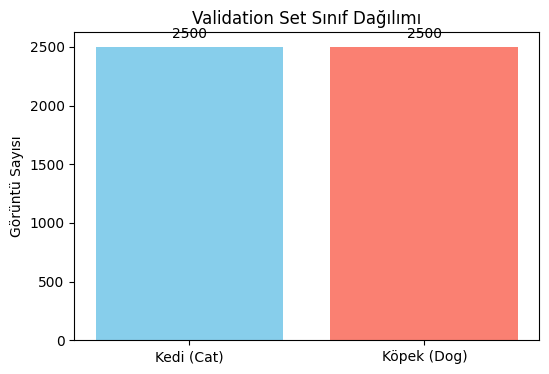

Veri setiniz mükemmel dengededir (2500 Kedi, 2500 Köpek).


In [22]:
import matplotlib.pyplot as plt

# Projede kullanılan klasör yapısından alınan sayılar:
class_labels = ['Kedi (Cat)', 'Köpek (Dog)']
counts = [2500, 2500] 

plt.figure(figsize=(6, 4))
bars = plt.bar(class_labels, counts, color=['skyblue', 'salmon'])

# Çubukların üzerine sayıları ekle
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom', fontsize=10)

plt.title('Validation Set Sınıf Dağılımı')
plt.ylabel('Görüntü Sayısı')
plt.show()

print("Veri setiniz mükemmel dengededir (2500 Kedi, 2500 Köpek).")